In [2]:
import pandas as pd
import numpy as np
import ser
import lib_tree
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, precision_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score1
import time
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

## SER

In [3]:
Final_Data_S1= pd.read_csv("final_H358.csv")
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin([ 3.0,4.0])].index, 'labels']=2.0

ys = Final_Data_S1.labels
Xs= Final_Data_S1.drop(['Time', 'labels'], axis=1)

In [4]:
train= pd.read_csv("train_data.csv")
test= pd.read_csv("test_data.csv")

yt = train.labels
Xt= train.drop([ 'labels'], axis=1)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.9, stratify=yt,  random_state = 42)
X_train_t = X_train_t.to_numpy()
y_train_t= y_train_t.to_numpy()
y_test_t = test.labels
X_test_t = test.drop([ 'labels'], axis=1)

In [5]:
clf = DecisionTreeClassifier(max_depth=1)
clf = clf.fit(Xs, ys)

In [ ]:
SER = copy.deepcopy(clf)
ser.SER(0,SER, X_train_t, y_train_t, original_ser=True)
print('ser original accuracy:', SER.score(X_test_t, y_test_t))
y_pred = SER.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
f1_weighted = f1_score( y_test_t,y_pred, average='weighted')
print('Weighted F1 score: ', f1_weighted)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
print("accuracy:",accuracy_score(y_test_t, y_pred))
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser*:")
print(cm)

ser original accuracy: 0.8314606741573034
Weighted F1 score:  0.8317116008142094
precision: [0.93717277 0.52459016 0.73333333]
recall; [0.92746114 0.66666667 0.42307692]
fscore: [0.93229167 0.58715596 0.53658537]
support: [193  48  26]
accuracy: 0.8314606741573034
Confusion Matrix ser*:
[[179  14   0]
 [ 12  32   4]
 [  0  15  11]]


Micro-averaged One-vs-Rest ROC AUC score:
0.8736
Macro-averaged One-vs-Rest ROC AUC score:
0.7843


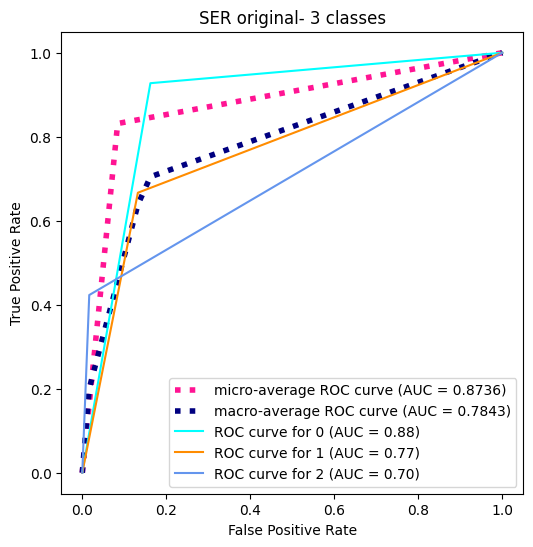

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
label_binarizer = LabelBinarizer().fit(y_test_t)
y_onehot_test = label_binarizer.transform(y_test_t)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([0])

import matplotlib.pyplot as plt

y_pred_onehot = label_binarizer.transform(y_pred)



from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


from sklearn.metrics import auc, roc_curve
n_classes = 3
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.4f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.4f}")
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SER original- 3 classes")
plt.legend()
plt.show()

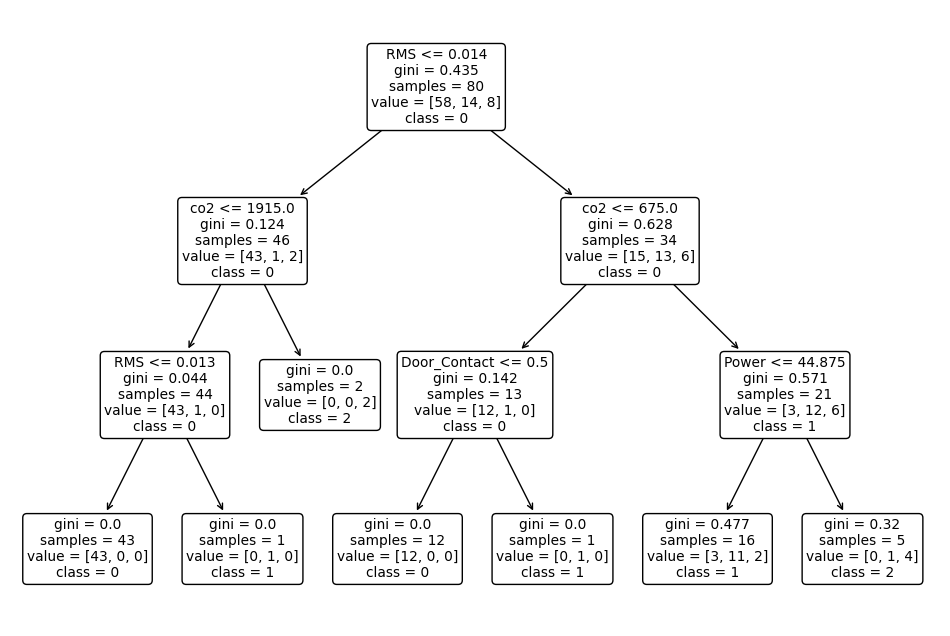

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(SER, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1','2'], rounded=True)
plt.show()

### SER*

In [6]:
target_names = ['class 0', 'class 1', 'class 2']

In [7]:
cl_no_red = [1]
Nkmin = sum(y_train_t == cl_no_red)
root_source_values = lib_tree.get_node_distribution(clf, 0).reshape(-1)
props_s = root_source_values
props_s = props_s / sum(props_s)
props_t = np.zeros(props_s.size)
for k in range(props_s.size):
    props_t[k] = np.sum(y_train_t == k) / y_train_t.size
coeffs = np.divide(props_t, props_s)

In [ ]:
ser_imb3 = copy.deepcopy(clf)
ser.SER(0, ser_imb3, X_train_t, y_train_t, original_ser=False, no_red_on_cl=True, cl_no_red=cl_no_red, no_ext_on_cl=True, cl_no_ext=cl_no_red, ext_cond=True, leaf_loss_quantify=True, leaf_loss_threshold=0.2, coeffs=coeffs, root_source_values=root_source_values, Nkmin=Nkmin)
print('ser* accuracy:', ser_imb3.score(X_test_t, y_test_t))
y_pred = ser_imb3.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
f1_weighted = f1_score( y_test_t, y_pred, average='weighted')
print('Weighted F1 score: ', f1_weighted)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser*:")
print(cm)
print('\n')
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
print("accuracy per class", accuracy_per_class)
macro_precision = precision_score(y_test_t, y_pred, average='macro')
micro_precision = precision_score(y_test_t, y_pred, average='micro')

# Calculate weighted average precision
weighted_precision = precision_score(y_test_t, y_pred, average='weighted')
print('macro precision:', macro_precision )

print('micro precision:', micro_precision )

print('weighted_precision:', weighted_precision )

print(classification_report(y_test_t, y_pred, target_names=target_names))

ser* accuracy: 0.8164794007490637
Weighted F1 score:  0.8176393681126938
precision: [0.93617021 0.53333333 0.52631579]
recall; [0.9119171  0.66666667 0.38461538]
fscore: [0.92388451 0.59259259 0.44444444]
support: [193  48  26]
Confusion Matrix ser*:
[[176  13   4]
 [ 11  32   5]
 [  1  15  10]]


accuracy per class [0.9119171  0.66666667 0.38461538]
macro precision: 0.6652731118576583
micro precision: 0.8164794007490637
weighted_precision: 0.8238391819855638
              precision    recall  f1-score   support

     class 0       0.94      0.91      0.92       193
     class 1       0.53      0.67      0.59        48
     class 2       0.53      0.38      0.44        26

    accuracy                           0.82       267
   macro avg       0.67      0.65      0.65       267
weighted avg       0.82      0.82      0.82       267



Micro-averaged One-vs-Rest ROC AUC score:
0.8624
Macro-averaged One-vs-Rest ROC AUC score:
0.7726


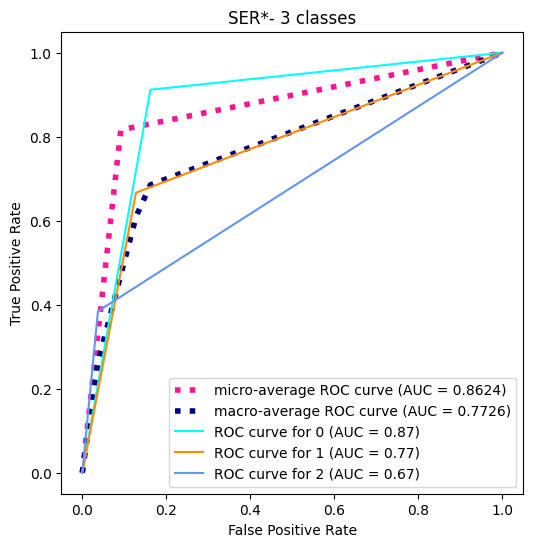

In [ ]:
label_binarizer = LabelBinarizer().fit(y_test_t)
y_onehot_test = label_binarizer.transform(y_test_t)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([0])
y_pred_onehot = label_binarizer.transform(y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
n_classes = 3
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.4f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.4f}")
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SER*- 3 classes")
plt.legend()
plt.show()

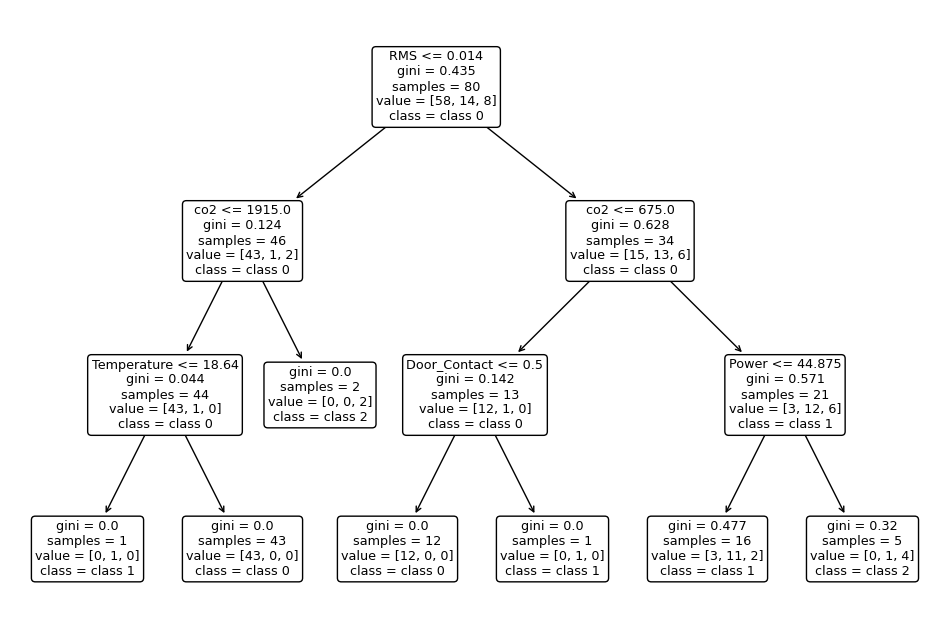

In [16]:
plt.figure(figsize=(12, 8))
plot_tree(ser_imb3, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=target_names,  rounded=True)
plt.show()